# 第6章 学習に関するテクニック

- 第6章ではNN学習においてキーとなる重要なアイデアを説明する
    
    - 最適な重みパラメータを探索する**最適化手法**
    - 重みパラメータの初期値
    - ハイパラの設定方法
    - 過学習への対策(**Weight decay, Dropout等の正則化手法**)
    - Batch Normalization

In [1]:
# %cd /content/drive/MyDrive/work/
# !git clone https://github.com/oreilly-japan/deep-learning-from-scratch.git

In [2]:
# from google.colab import drive
# drive.mount('/content/drive/')
# %cd /content/drive/MyDrive/work/deep-learning-from-scratch/ch04/
# %cd /deep-learning-from-scratch

In [3]:
import numpy as np
import logging
import sys
import os
from pathlib import Path

# importディレクトリの追加
# sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
sys.path.append(os.path.join(Path().resolve(), 'refs'))
print(sys.path)

# プロキシの設定

['/home/jovyan/work/dl_study/01_deep-learning-from-scratch', '/opt/conda/lib/python38.zip', '/opt/conda/lib/python3.8', '/opt/conda/lib/python3.8/lib-dynload', '', '/opt/conda/lib/python3.8/site-packages', '/opt/conda/lib/python3.8/site-packages/IPython/extensions', '/home/jovyan/.ipython', '/home/jovyan/work/dl_study/01_deep-learning-from-scratch/refs']


In [ ]:
import urllib.request
print(urllib.request.getproxies())

In [5]:
import matplotlib as plt
# matplotlibのサイズを大きくする
plt.rcParams['figure.figsize'] = (16.0, 6.0)

## 6.1 パラメータの更新

- NNが学習する目的は, 損失関数の値をできるだけ小さくするパラメータを見つけること

- NNの最適化はとても難しい問題
    - パラメータ空間が非常に複雑で最適解が簡単には見つけられない
    - DNNではパラメータ数がより膨大になる
    

- パラメータの勾配を使って最適化を行うアプローチは**確率的勾配降下法**(Stocastic Gradient Descent)と呼ばれる
    - SGDは単純な手法で, もっとスマートな方法が存在する
    

### 6.1.2 SGD



$$
{\textbf W \leftarrow \textbf W - \eta\frac{\delta L}{\delta \textbf W}}
$$

In [6]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

- 最適化を行うクラスを分離して実装することで, 機能のモジュール化が容易になる
- 最適化時のI/Fを`update(params, grads)`にすることで, 色々な最適化を実装できる

## 6.1.3 SGDの欠点

- SGDは実装が単純だが、場合によっては非効率
    - SGDは関数の形状が等法的(伸びた形)だと, 非効率な探索になってしまう
- SGDの非効率な探索経路となる根本的な原因は, **勾配方向が本来の最小値ではない方向を指しているから**

## 6.1.4. Moemntum

- モーメンタム(Momentum)は運動量という意味
- 数式で表すと以下のようになる

$$

T B W

$$

- vという変数が登場し, これは物理で言うところの速度に対応する
- 物体が勾配方向に力を受け, その力によって物体の速度が加算されるという物理法則を表す
- $ \alpha \textbf v $は物体が何もちから力を受けないときに, 徐々に減速するための役割を担う
    - αには0.9等の値を設定する
    - 物理で言うところの空気抵抗や摩擦


In [7]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

- vは物体の速度を保持する
- vは初期化時は何も保持せず, `update()`が初めに呼ばれた際に更新される

## 6.1.5 AdaGrad

- NNの学習では学習係数$\eta$が重要になる
- 学習が進むにつれて学習係数を小さくする手法がある(**学習係数の減衰**)
- AdaGradは学習係数の減衰を、各レイヤのパラメータの要素ごとに個別に実行する方法

$$
\begin{align}
h \leftarrow h + \frac{\partial L}{\partial \textbf W} \odot \frac{\partial L}{\partial \boldsymbol W}  \tag{6.5} \\
\boldsymbol W \leftarrow \boldsymbol W - \eta \frac{1}{\sqrt h} \frac{\partial L}{\partial \boldsymbol W} \tag{6.6}
\end{align}
$$

- $ h $はこれまで経験した勾配の値を二乗和として保持する
- パラメータ更新の際に, $ \frac{1}{\sqrt{h}} $を乗算することで学習率をスケールする

- これによりパラメータの要素の中で、大きく更新された要素は学習係数が小さくなる

- AdaGradは過去の勾配を二乗和としてすべて記録するため, 学習を進めるほど更新度合は小さくなる
    - 無限に学習を行うと, そのうち更新量は0になり, **まったく更新されなくなる**
    - この問題を改善したものが**RMSProp**

### AdaGradの実装

In [8]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            
            # 1e-7を加算しているのは0除算防止のため
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

## 6.1.6 Adam

## 6.3 Batch Normalization

- 重みの初期値を適切に設定すれば, 各層のアクティベーション分布は適度な広がりを持ち, 学習がスムーズになる
- つまり, 学習をスムーズにしたければ, 各層で適度な広がりを持つように, 強制的にアクティベーションの分布を調整すれば良い(**Batch Normalization**)

### Batch Normのメリット

- 学習を早く進行させることができる(学習係数を大きくすることができる)
- 初期値にあまり依存しない(初期値に対して, 神経質にならなくても良い)
- 過学習を抑制する(Dropout等の必要性を減らす)

![fig6-16](./images/fig6-16.PNG)

- 上記を行う為に, データ分布の正規化を行うBatch Normalizationレイヤを導入する
- 学習を行う際のミニバッチを単位として, **ミニバッチごとに正規化する**
    - データの分布が平均0, 分散1になるようにする

$$
    \begin{align}
    \mu_B \leftarrow \frac{1}{m}\sum x_i \\
    \sigma^2_B \leftarrow \frac{1}{m}\sum (xi - \mu_B)^2 \\
    \hat x_i \leftarrow \frac{x_i - \mu_B}{\sqrt{\sigma^2_B + \epsilon}} \\
    y_i \leftarrow \gamma \hat x_i + \beta
    \end{align}
$$ 

- ミニバッチ$B = \{ x_1, x_2, \cdots, x_m\} $の集合に対して, 平均$ \mu_B $, 分散$ \sigma^2_B $を求める
- その後, 以下の正規化を行う
- ここで$ \epsilon $はゼロ除算を防止するための, 小さな値(10e-7など)
- $\gamma$と$\beta$は 学習によって調整されるパラメータ
    - 最初は$\gamma =1, \beta = 0 $からスタートする
    
- Batch Normの計算グラフは以下のようになる

![fig6-17](./images/fig6-17.PNG)

## 6.2.3 Batch Normalizationの評価

============== 1/16 ==============
epoch:0 | 0.099 - 0.108
epoch:1 | 0.097 - 0.104
epoch:2 | 0.097 - 0.128
epoch:3 | 0.097 - 0.152


/home/jovyan/work/dl_study/01_deep-learning-from-scratch/refs/common/functions.py:32: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=-1, keepdims=True)   # オーバーフロー対策


epoch:4 | 0.097 - 0.171
epoch:5 | 0.097 - 0.186
epoch:6 | 0.097 - 0.199
epoch:7 | 0.097 - 0.216
epoch:8 | 0.097 - 0.228
epoch:9 | 0.097 - 0.238
epoch:10 | 0.097 - 0.253
epoch:11 | 0.097 - 0.257
epoch:12 | 0.097 - 0.278
epoch:13 | 0.097 - 0.303
epoch:14 | 0.097 - 0.307
epoch:15 | 0.097 - 0.315
epoch:16 | 0.097 - 0.33


No handles with labels found to put in legend.


epoch:17 | 0.097 - 0.342
epoch:18 | 0.097 - 0.365
epoch:19 | 0.097 - 0.378
============== 2/16 ==============
epoch:0 | 0.097 - 0.097


/home/jovyan/work/dl_study/01_deep-learning-from-scratch/refs/common/functions.py:32: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=-1, keepdims=True)   # オーバーフロー対策


epoch:1 | 0.097 - 0.092
epoch:2 | 0.097 - 0.117
epoch:3 | 0.097 - 0.135
epoch:4 | 0.097 - 0.15
epoch:5 | 0.097 - 0.164
epoch:6 | 0.097 - 0.192
epoch:7 | 0.097 - 0.223
epoch:8 | 0.097 - 0.228
epoch:9 | 0.097 - 0.265
epoch:10 | 0.097 - 0.288
epoch:11 | 0.097 - 0.309
epoch:12 | 0.097 - 0.335
epoch:13 | 0.097 - 0.352
epoch:14 | 0.097 - 0.382
epoch:15 | 0.097 - 0.413
epoch:16 | 0.097 - 0.429


No handles with labels found to put in legend.


epoch:17 | 0.097 - 0.446
epoch:18 | 0.097 - 0.466
epoch:19 | 0.097 - 0.475
============== 3/16 ==============
epoch:0 | 0.087 - 0.095
epoch:1 | 0.322 - 0.121
epoch:2 | 0.479 - 0.167
epoch:3 | 0.58 - 0.213
epoch:4 | 0.631 - 0.244
epoch:5 | 0.689 - 0.294
epoch:6 | 0.762 - 0.33
epoch:7 | 0.811 - 0.367
epoch:8 | 0.838 - 0.395
epoch:9 | 0.869 - 0.415
epoch:10 | 0.886 - 0.451
epoch:11 | 0.92 - 0.473
epoch:12 | 0.928 - 0.497
epoch:13 | 0.936 - 0.533
epoch:14 | 0.946 - 0.539
epoch:15 | 0.951 - 0.554
epoch:16 | 0.957 - 0.579
epoch:17 | 0.966 - 0.6
epoch:18 | 0.973 - 0.618


No handles with labels found to put in legend.


epoch:19 | 0.978 - 0.629
============== 4/16 ==============
epoch:0 | 0.12 - 0.104
epoch:1 | 0.182 - 0.127
epoch:2 | 0.312 - 0.19
epoch:3 | 0.429 - 0.273
epoch:4 | 0.504 - 0.346
epoch:5 | 0.583 - 0.408
epoch:6 | 0.625 - 0.453
epoch:7 | 0.688 - 0.493
epoch:8 | 0.714 - 0.539
epoch:9 | 0.738 - 0.573
epoch:10 | 0.762 - 0.604
epoch:11 | 0.77 - 0.634
epoch:12 | 0.785 - 0.653
epoch:13 | 0.805 - 0.679
epoch:14 | 0.805 - 0.7
epoch:15 | 0.814 - 0.722
epoch:16 | 0.824 - 0.729
epoch:17 | 0.839 - 0.751


No handles with labels found to put in legend.


epoch:18 | 0.839 - 0.766
epoch:19 | 0.851 - 0.772
============== 5/16 ==============
epoch:0 | 0.113 - 0.109
epoch:1 | 0.119 - 0.129
epoch:2 | 0.138 - 0.244
epoch:3 | 0.16 - 0.409
epoch:4 | 0.172 - 0.508
epoch:5 | 0.179 - 0.559
epoch:6 | 0.185 - 0.626
epoch:7 | 0.197 - 0.662
epoch:8 | 0.215 - 0.689
epoch:9 | 0.215 - 0.717
epoch:10 | 0.233 - 0.739
epoch:11 | 0.234 - 0.763
epoch:12 | 0.248 - 0.775
epoch:13 | 0.263 - 0.794
epoch:14 | 0.277 - 0.806
epoch:15 | 0.279 - 0.821
epoch:16 | 0.286 - 0.832


No handles with labels found to put in legend.


epoch:17 | 0.304 - 0.841
epoch:18 | 0.317 - 0.854
epoch:19 | 0.333 - 0.863
============== 6/16 ==============
epoch:0 | 0.129 - 0.098
epoch:1 | 0.124 - 0.248
epoch:2 | 0.124 - 0.5
epoch:3 | 0.117 - 0.589
epoch:4 | 0.117 - 0.656
epoch:5 | 0.117 - 0.684
epoch:6 | 0.116 - 0.73
epoch:7 | 0.116 - 0.758
epoch:8 | 0.131 - 0.79
epoch:9 | 0.148 - 0.815
epoch:10 | 0.121 - 0.843
epoch:11 | 0.116 - 0.863
epoch:12 | 0.117 - 0.879
epoch:13 | 0.16 - 0.89
epoch:14 | 0.157 - 0.899
epoch:15 | 0.116 - 0.905
epoch:16 | 0.128 - 0.914
epoch:17 | 0.134 - 0.922
epoch:18 | 0.116 - 0.933


No handles with labels found to put in legend.


epoch:19 | 0.155 - 0.94
============== 7/16 ==============
epoch:0 | 0.105 - 0.093
epoch:1 | 0.159 - 0.175
epoch:2 | 0.116 - 0.561
epoch:3 | 0.117 - 0.728
epoch:4 | 0.116 - 0.806
epoch:5 | 0.117 - 0.837
epoch:6 | 0.117 - 0.883
epoch:7 | 0.117 - 0.89
epoch:8 | 0.117 - 0.917
epoch:9 | 0.117 - 0.938
epoch:10 | 0.117 - 0.946
epoch:11 | 0.117 - 0.951
epoch:12 | 0.117 - 0.955
epoch:13 | 0.116 - 0.961
epoch:14 | 0.117 - 0.969
epoch:15 | 0.116 - 0.979
epoch:16 | 0.116 - 0.984
epoch:17 | 0.116 - 0.989
epoch:18 | 0.116 - 0.991

No handles with labels found to put in legend.



epoch:19 | 0.116 - 0.989
============== 8/16 ==============
epoch:0 | 0.116 - 0.097
epoch:1 | 0.105 - 0.412
epoch:2 | 0.116 - 0.628
epoch:3 | 0.116 - 0.72
epoch:4 | 0.117 - 0.774
epoch:5 | 0.116 - 0.827
epoch:6 | 0.116 - 0.873
epoch:7 | 0.117 - 0.906
epoch:8 | 0.117 - 0.947
epoch:9 | 0.117 - 0.959
epoch:10 | 0.117 - 0.97
epoch:11 | 0.117 - 0.976
epoch:12 | 0.116 - 0.98
epoch:13 | 0.117 - 0.989
epoch:14 | 0.117 - 0.995
epoch:15 | 0.117 - 0.994
epoch:16 | 0.117 - 0.996
epoch:17 | 0.117 - 0.999


No handles with labels found to put in legend.


epoch:18 | 0.117 - 0.999
epoch:19 | 0.116 - 0.999
============== 9/16 ==============
epoch:0 | 0.117 - 0.149
epoch:1 | 0.116 - 0.457
epoch:2 | 0.117 - 0.671
epoch:3 | 0.116 - 0.777
epoch:4 | 0.116 - 0.81
epoch:5 | 0.117 - 0.88
epoch:6 | 0.117 - 0.927
epoch:7 | 0.117 - 0.967
epoch:8 | 0.116 - 0.982
epoch:9 | 0.117 - 0.99
epoch:10 | 0.116 - 0.995
epoch:11 | 0.116 - 0.998
epoch:12 | 0.116 - 0.998
epoch:13 | 0.116 - 1.0
epoch:14 | 0.116 - 1.0
epoch:15 | 0.116 - 1.0
epoch:16 | 0.116 - 1.0
epoch:17 | 0.116 - 1.0


No handles with labels found to put in legend.


epoch:18 | 0.116 - 1.0
epoch:19 | 0.116 - 1.0
============== 10/16 ==============
epoch:0 | 0.093 - 0.132
epoch:1 | 0.117 - 0.566
epoch:2 | 0.117 - 0.799
epoch:3 | 0.117 - 0.835
epoch:4 | 0.116 - 0.854
epoch:5 | 0.116 - 0.852
epoch:6 | 0.116 - 0.893
epoch:7 | 0.116 - 0.951
epoch:8 | 0.116 - 0.909
epoch:9 | 0.116 - 0.983
epoch:10 | 0.117 - 0.988
epoch:11 | 0.116 - 0.99
epoch:12 | 0.116 - 0.994
epoch:13 | 0.116 - 0.996
epoch:14 | 0.117 - 0.996
epoch:15 | 0.117 - 0.996
epoch:16 | 0.117 - 0.996
epoch:17 | 0.117 - 0.997


No handles with labels found to put in legend.


epoch:18 | 0.116 - 0.997
epoch:19 | 0.116 - 0.999
============== 11/16 ==============
epoch:0 | 0.092 - 0.16
epoch:1 | 0.117 - 0.578
epoch:2 | 0.117 - 0.629
epoch:3 | 0.117 - 0.726
epoch:4 | 0.117 - 0.749
epoch:5 | 0.117 - 0.717
epoch:6 | 0.117 - 0.784
epoch:7 | 0.117 - 0.803
epoch:8 | 0.117 - 0.696
epoch:9 | 0.117 - 0.775
epoch:10 | 0.117 - 0.848
epoch:11 | 0.117 - 0.887
epoch:12 | 0.116 - 0.888
epoch:13 | 0.116 - 0.892
epoch:14 | 0.116 - 0.897
epoch:15 | 0.116 - 0.899
epoch:16 | 0.116 - 0.902
epoch:17 | 0.116 - 0.901


No handles with labels found to put in legend.


epoch:18 | 0.116 - 0.898
epoch:19 | 0.116 - 0.891
============== 12/16 ==============
epoch:0 | 0.116 - 0.211
epoch:1 | 0.117 - 0.53
epoch:2 | 0.117 - 0.638
epoch:3 | 0.117 - 0.647
epoch:4 | 0.117 - 0.672
epoch:5 | 0.117 - 0.699
epoch:6 | 0.117 - 0.686
epoch:7 | 0.117 - 0.761
epoch:8 | 0.117 - 0.74
epoch:9 | 0.117 - 0.767
epoch:10 | 0.117 - 0.789
epoch:11 | 0.117 - 0.798
epoch:12 | 0.117 - 0.68
epoch:13 | 0.117 - 0.799
epoch:14 | 0.117 - 0.803
epoch:15 | 0.117 - 0.796
epoch:16 | 0.117 - 0.797
epoch:17 | 0.117 - 0.796


No handles with labels found to put in legend.


epoch:18 | 0.117 - 0.807
epoch:19 | 0.117 - 0.802
============== 13/16 ==============
epoch:0 | 0.117 - 0.145
epoch:1 | 0.117 - 0.4
epoch:2 | 0.117 - 0.44
epoch:3 | 0.116 - 0.464
epoch:4 | 0.117 - 0.495
epoch:5 | 0.117 - 0.519
epoch:6 | 0.117 - 0.501
epoch:7 | 0.117 - 0.515
epoch:8 | 0.117 - 0.524
epoch:9 | 0.116 - 0.534
epoch:10 | 0.116 - 0.545
epoch:11 | 0.116 - 0.54
epoch:12 | 0.116 - 0.522
epoch:13 | 0.116 - 0.616
epoch:14 | 0.116 - 0.617
epoch:15 | 0.116 - 0.62
epoch:16 | 0.116 - 0.62
epoch:17 | 0.116 - 0.617


No handles with labels found to put in legend.


epoch:18 | 0.116 - 0.623
epoch:19 | 0.116 - 0.624
============== 14/16 ==============
epoch:0 | 0.087 - 0.097
epoch:1 | 0.117 - 0.297
epoch:2 | 0.116 - 0.393
epoch:3 | 0.117 - 0.392
epoch:4 | 0.117 - 0.401
epoch:5 | 0.117 - 0.404
epoch:6 | 0.117 - 0.427
epoch:7 | 0.117 - 0.417
epoch:8 | 0.117 - 0.413
epoch:9 | 0.117 - 0.505
epoch:10 | 0.117 - 0.523
epoch:11 | 0.117 - 0.511
epoch:12 | 0.117 - 0.523
epoch:13 | 0.117 - 0.519
epoch:14 | 0.117 - 0.524
epoch:15 | 0.117 - 0.524
epoch:16 | 0.117 - 0.525
epoch:17 | 0.117 - 0.521


No handles with labels found to put in legend.


epoch:18 | 0.117 - 0.522
epoch:19 | 0.117 - 0.525
============== 15/16 ==============
epoch:0 | 0.097 - 0.103
epoch:1 | 0.117 - 0.211
epoch:2 | 0.117 - 0.361
epoch:3 | 0.117 - 0.408
epoch:4 | 0.117 - 0.408
epoch:5 | 0.116 - 0.405
epoch:6 | 0.116 - 0.418
epoch:7 | 0.116 - 0.444
epoch:8 | 0.116 - 0.424
epoch:9 | 0.116 - 0.426
epoch:10 | 0.116 - 0.429
epoch:11 | 0.116 - 0.429
epoch:12 | 0.116 - 0.448
epoch:13 | 0.116 - 0.434
epoch:14 | 0.116 - 0.421
epoch:15 | 0.116 - 0.42
epoch:16 | 0.116 - 0.431
epoch:17 | 0.116 - 0.431


No handles with labels found to put in legend.


epoch:18 | 0.116 - 0.432
epoch:19 | 0.116 - 0.516
============== 16/16 ==============
epoch:0 | 0.099 - 0.124
epoch:1 | 0.116 - 0.415
epoch:2 | 0.116 - 0.469
epoch:3 | 0.117 - 0.45
epoch:4 | 0.117 - 0.477
epoch:5 | 0.117 - 0.491
epoch:6 | 0.117 - 0.494
epoch:7 | 0.117 - 0.5
epoch:8 | 0.117 - 0.505
epoch:9 | 0.117 - 0.557
epoch:10 | 0.117 - 0.503
epoch:11 | 0.117 - 0.591
epoch:12 | 0.117 - 0.602
epoch:13 | 0.117 - 0.589
epoch:14 | 0.117 - 0.601
epoch:15 | 0.117 - 0.61
epoch:16 | 0.117 - 0.609
epoch:17 | 0.117 - 0.609
epoch:18 | 0.117 - 0.613
epoch:19 | 0.117 - 0.611


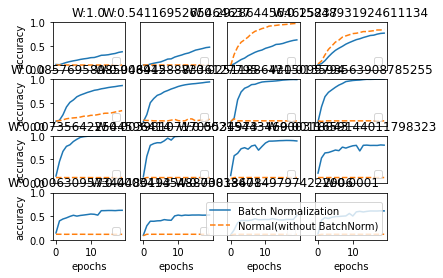

In [9]:
import ch06.batch_norm_test

- ほとんどすべてのケースでBatch Normを使用した方が学習の進みが早い
- Batch Normを使用せず、初期値のスケールが不適切な場合は, ほぼ学習が進行しない
  - W=0.1584, W=0.2986のケースのみ学習が進んでる

### Batch Normまとめ

- Batch Normを使用することで, 学習の進行を促進させることができる
- Batch Normを重みの初期値について頑健になる

## 6.4 正則化

- 機械学習では**過学習（overfitting）**が問題になることが多くある
  - 過学習はTrainに過剰適合し, Testへの適応性がなくなること
- 機械学習では, 汎化性能が大事
  - まだ見ぬデータであっても, 正しく識別できてほしい

### 6.4.1. 過学習

- 過学習が起きる要因として以下の二つが挙げられる
  - パラメータを大量に持ち、表現力の高いモデルである
  - 訓練データが少ない

### 過学習の再現

In [10]:
# import ch06.overfit_weight_decay

- trainとtestの精度のにおおよそ0.2くらいの隔たりがある
- これは, 訓練データだけに適応してしまったから

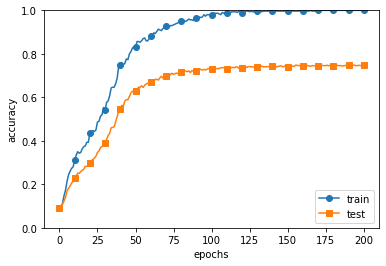

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために, 学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

network = MultiLayerNet(input_size=784,
                        hidden_size_list=[100, 100, 100, 100, 100, 100],
                        output_size=10)

optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list, train_acc_list, test_acc_list = [], [], []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

# 3.グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## 6.4.2. Weight decay

- **Weight decay(荷重減衰)**は過学習抑制のために昔からよく用いられている
- Weight decayは学習過程で, <u>大きな重みをもつことに対してペナルティを課す</u>
    - 過学習は重みパラメータが大きな値をとることによって発生することが多くある

- Weight decayは, **重みの2乗ノルム(L2ノルム)を損失関数に加える**

- L2ノルムのWeight decayは, $\frac{1}{2}\lambda\textbf W^2$になる
    - $\lambda$は正則化の強さを制御するハイパラ
    - 先頭の$\frac{1}{2}$は微分結果を$\lambda \textbf W$にするための調整用定数

---
- **順伝播時は損失関数に$\frac{1}{2}\lambda\textbf W^2$を加算する**
- **誤差逆伝播時は正則化項の微分$\lambda \textbf W$を加算する**
---

- L2ノルムは, 各要素の2乗和に対応し, 以下で計算できる
  - $\textbf W = \sqrt{(w_1^2 + w_2^2 + \cdot + w_n^2)}$

### Weight Decayの実装

In [ ]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class MultiLayerNet:
    """全結合による多層ニューラルネットワーク

    Parameters
    ----------
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    weight_decay_lambda : Weight Decay（L2ノルム）の強さ
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.weight_decay_lambda = weight_decay_lambda
        self.params = {}

        # 重みの初期化
        self.__init_weight(weight_init_std)

        # レイヤの生成
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
            self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """重みの初期値設定

        Parameters
        ----------
        weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
            'relu'または'he'を指定した場合は「Heの初期値」を設定
            'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLUを使う場合に推奨される初期値
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoidを使う場合に推奨される初期値

            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """損失関数を求める

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        損失関数の値
        """
        y = self.predict(x)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        """勾配を求める（数値微分）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """勾配を求める（誤差逆伝搬法）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.layers['Affine' + str(idx)].W
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

        return grads


epoch:0, train acc:0.09, test acc:0.0879
epoch:1, train acc:0.14, test acc:0.1027
epoch:2, train acc:0.17, test acc:0.1218
epoch:3, train acc:0.20333333333333334, test acc:0.1352
epoch:4, train acc:0.23333333333333334, test acc:0.1497
epoch:5, train acc:0.26666666666666666, test acc:0.1676
epoch:6, train acc:0.2733333333333333, test acc:0.1852
epoch:7, train acc:0.3, test acc:0.2061
epoch:8, train acc:0.33666666666666667, test acc:0.2299
epoch:9, train acc:0.36666666666666664, test acc:0.2596
epoch:10, train acc:0.39666666666666667, test acc:0.2824
epoch:11, train acc:0.44333333333333336, test acc:0.298
epoch:12, train acc:0.4866666666666667, test acc:0.3298
epoch:13, train acc:0.5, test acc:0.3425
epoch:14, train acc:0.5233333333333333, test acc:0.3584
epoch:15, train acc:0.5366666666666666, test acc:0.364
epoch:16, train acc:0.5666666666666667, test acc:0.3756
epoch:17, train acc:0.5733333333333334, test acc:0.399
epoch:18, train acc:0.6133333333333333, test acc:0.429
epoch:19, train

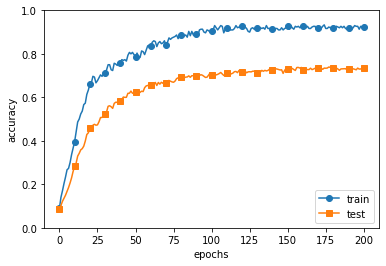

In [13]:
import ch06.overfit_weight_decay

- Weight decayを用いると訓練誤差とテスト誤差の**隔たりが縮小している**
- 訓練データの認識精度が100%に達していない

## 6.4.3 Dropout

- NNモデルが複雑になってくると, Weight Decayだけでは対応できない。そこで, Dropoutが使われる。
- Dropoutはニューロンを**ランダムに消去しながら学習する**手法
  - 消去されたニューロンは信号の伝達を行わなくなる
- 訓練時は, データが流れるたびに消去するニューロンをランダムに選択する
- テスト時には, 各ニューロンの出力に対して, 訓練時に消去した割合を乗算して出力する(?)

### Dropoutの実装

In [19]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
        
    def forward(self, x, train_flg=True):
        if train_flg:
            # 学習時の順伝播では, ランダムにニューロンを消去(順伝播の度にやる)
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        
        else:
            # テスト時の順伝播では, 削除した比率を入力データに乗算
            return x * (1.0 - self.dropout_ratio)
        
    def backward(self, dout):
        # 逆伝播時は, 最後に消去したニューロンを保持しておいて, 対応する特徴次元のみ逆伝播する
        # (ReLuの逆伝播と一緒)
        return dout * self.mask

train loss:2.2913409541967176
=== epoch:1, train acc:0.12333333333333334, test acc:0.1184 ===
train loss:2.2891524017374967
train loss:2.309441176767216
train loss:2.2947636102641793
=== epoch:2, train acc:0.13333333333333333, test acc:0.1197 ===
train loss:2.2938938753294082
train loss:2.297403408317332
train loss:2.316324365756231
=== epoch:3, train acc:0.13666666666666666, test acc:0.1196 ===
train loss:2.3001099932473754
train loss:2.3047138545625914
train loss:2.2905787346076476
=== epoch:4, train acc:0.14, test acc:0.1202 ===
train loss:2.300898877950358
train loss:2.298896132477788
train loss:2.2841594017856224
=== epoch:5, train acc:0.14, test acc:0.1209 ===
train loss:2.2939784024835954
train loss:2.3047772577405947
train loss:2.2994618428027276
=== epoch:6, train acc:0.14666666666666667, test acc:0.1216 ===
train loss:2.2989168706181484
train loss:2.3172009821641253
train loss:2.288884139076271
=== epoch:7, train acc:0.14, test acc:0.1201 ===
train loss:2.288325609841046
trai

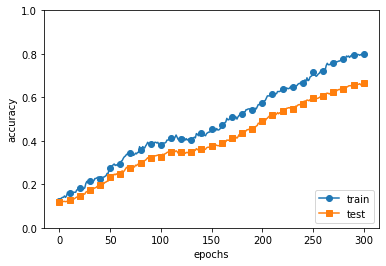

In [20]:
import ch06.overfit_dropout

- **Dropoutを用いれば, 表現力の高いネットワークであっても過学習を抑制することができる**

- アンサンブル学習はDropoutと近い関係がある
  - Dropoutが学習時にランダムにニューロンを消去することは, <u>毎回異なるモデル学習させているのと同じ</u>と解釈できる
  - 推論時に消去した割合を乗算するのは, <u>モデルの平均を取っているのと同じ</u>

## 6.5 ハイパーパラメータの検証

- テストデータを使ってハイパラ性能を評価してはならない
- テストデータを使ってハイパラを調整すれば, ハイパラはテストデータに対して過学習を起こす
- ハイパラを調整する際には, ハイパラ専用の確認データが必要になる
    - ハイパラ調整用のデータは一般に**検証データ(Validation data)**と呼ぶ

In [29]:
from common.util import shuffle_dataset 

(x_train, t_train), (x_test, t_test) = load_mnist()

# 訓練データをシャッフル
x_train, t_train = shuffle_dataset(x_train, t_train)

# 検証データの分割
validation_rate = 0.2
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]

x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

## 6.5.2 ハイパーパラメータの最適化

- ハイパラの最適化を行う上で重要なポイントは, **良い値が存在する範囲を徐々に絞りこむ**こと
- 最初は大まかに範囲を設定し, その範囲からランダムにハイパラをサンプリングし, 精度を評価する
- 複数回サンプリングして精度を観察し, その結果から**ハイパラの良い値の範囲を狭めていく**
- これにより, 適切なハイパーパラメータの範囲を徐々に限定していくことができる。

- DNNの学習には多くの時間が必要になる
- そのため, **筋の悪いハイパラは早い段階で見切りをつける必要がある**
    - ハイパラ最適化において, 学習エポックを小さくして, 1回の評価時間を短縮する
    
### ハイパラ最適化のステップ
1. ハイパラの範囲を設定する  
2. 設定された範囲からランダムにサンプリングする  
3. Step1でサンプルしたハイパラの値を使用して学習し, モデルの精度を評価する  
4. Step1とStep2を, ある回数(100回等)繰り返し, それらの精度結果から, ハイパラの範囲を狭める

---

- より良い最適化のためには**ベイズ最適化(bayesian optimization)**が有効

## 6.5.3. ハイパーパラメータ最適化の実装

- ここではMNISTデータセットを使って以下のハイパラを最適化する

  - 学習係数(Learning Rate) ・・・ $10^{-6}$から$10^{-2}$
  - Weight Decayの強さ(Weight Decay係数) ・・・ $10^{-8}$ から $10^-{4}$

In [32]:
weight_decay = 10 ** np.random.uniform(-8 -4)
lr = 10 ** np.random.uniform(-6 -2)

val acc:0.1 | lr:0.00019465351033138984, weight decay:4.116774452394081e-06
val acc:0.06 | lr:0.0004166899728079525, weight decay:1.3529940587707657e-06
val acc:0.12 | lr:1.4845905564748247e-05, weight decay:1.47392011606712e-06
val acc:0.08 | lr:1.8853759563277607e-06, weight decay:1.1258075736151401e-05
val acc:0.08 | lr:1.691307324183113e-05, weight decay:2.2549406852326138e-06
val acc:0.13 | lr:5.063193474765944e-05, weight decay:1.2636709234919416e-08
val acc:0.16 | lr:0.00014786722666573727, weight decay:1.8998489424537806e-08
val acc:0.06 | lr:9.0543089694386e-06, weight decay:1.0886256181145043e-07
val acc:0.08 | lr:8.461374277533981e-06, weight decay:6.167800003519975e-07
val acc:0.11 | lr:0.0009911883042294563, weight decay:5.986160633293107e-07
val acc:0.1 | lr:3.100376539297787e-06, weight decay:2.93873779456085e-06
val acc:0.14 | lr:9.823866211209317e-05, weight decay:1.7415566941914208e-06
val acc:0.4 | lr:0.002043554543536104, weight decay:1.0693640094613813e-07
val acc:

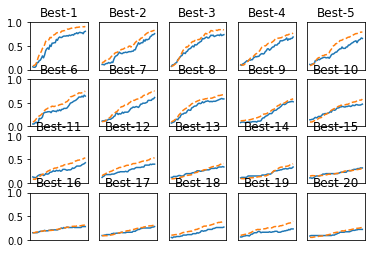

In [33]:
import ch06.hyperparameter_optimization

## 6.6 まとめ

- パラメータの更新方法には, SGDやMomentum, AdaGrad, Adamなどがある
- 重みの初期値の与え方は, 正しい学習を行う上で非常に重要
- 重みの初期化方法として, **Xavierの初期値**や **Heの初期値**が有効
  - ReLUはHeの初期化, Xavierの初期化はSigmoid関数等に適している
- Batch Normを用いることで, **学習を早く進めることができ, 初期値に対してロバストになる**
- 過学習を抑制する正則化技術として, **Weight decay**や**Dropout**がある
- ハイパラの探索は, 良い値が存在する範囲を徐々に絞りこみながら進めるのが効率が良い